# Auto-Encoder Proof-Of-Concept

In [22]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

sys.path.append(os.path.join(os.pardir, os.pardir))
from amlutils.task2.loading import load_train_set

from IPython.display import display

In [10]:
EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [11]:
X_train, y_train = load_train_set(os.path.join(os.pardir, 'data'))

display(X_train)

#X_train = X_train.fillna(0.0)
# Small hack, want that each signal is betweeb -1 and 1, so need to make
# signals the features and transform, then switch back.
X_train_scaled = X_train.T
X_train_scaled.values[:] = MinMaxScaler(feature_range=(-1,1)).fit_transform(X_train_scaled)
X_train_scaled = X_train_scaled.T

X_train = X_train.fillna(0.0)
X_train_scaled = X_train_scaled.fillna(0.0)

display(X_train_scaled)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x17832,x17833,x17834,x17835,x17836,x17837,x17838,x17839,x17840,x17841
id,,,,,,,,,,,,,,,,,,,,,
0,-64,-66,-69,-72,-75,-77,-80,-86,-89,-83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,505,500,496,492,487,480,475,476,483,495,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-21,-16,-12,-7,-3,0,1,2,4,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-211,-457,-635,-710,-715,-663,-573,-481,-401,-337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,36,32,29,25,22,19,17,15,12,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5112,-285,-303,-334,-376,-413,-432,-443,-451,-460,-468,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5113,50,51,50,48,46,44,42,39,36,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5114,-207,-225,-242,-258,-266,-271,-275,-279,-281,-284,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x17832,x17833,x17834,x17835,x17836,x17837,x17838,x17839,x17840,x17841
id,,,,,,,,,,,,,,,,,,,,,
0,-0.646817,-0.650924,-0.657084,-0.663244,-0.669405,-0.673511,-0.679671,-0.691992,-0.698152,-0.685832,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.579039,0.570306,0.563319,0.556332,0.547598,0.535371,0.526638,0.528384,0.540611,0.561572,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.255070,-0.251170,-0.248050,-0.244150,-0.241030,-0.238690,-0.237910,-0.237129,-0.235569,-0.234789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.237054,-0.520138,-0.724971,-0.811277,-0.817031,-0.757192,-0.653625,-0.547756,-0.455696,-0.382048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.091808,0.086158,0.081921,0.076271,0.072034,0.067797,0.064972,0.062147,0.057910,0.055085,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5112,-0.004863,-0.015805,-0.034650,-0.060182,-0.082675,-0.094225,-0.100912,-0.105775,-0.111246,-0.116109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5113,-0.322902,-0.320057,-0.322902,-0.328592,-0.334282,-0.339972,-0.345661,-0.354196,-0.362731,-0.371266,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5114,-0.331458,-0.351716,-0.370850,-0.388858,-0.397862,-0.403489,-0.407991,-0.412493,-0.414744,-0.418120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


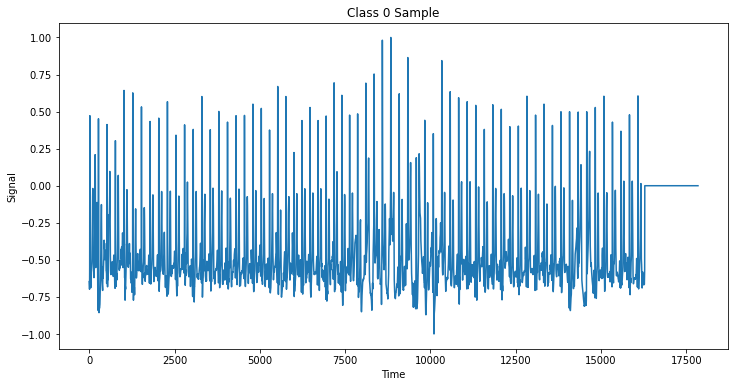

In [12]:
# Compare original with auto-encoded signal.
num_rows = 1
num_cols = 1
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12 * num_cols,6 * num_rows))

fig.set_facecolor('white')

axs.plot(list(range(17842)), X_train_scaled.iloc[0])
axs.set(xlabel='Time', ylabel='Signal', title='Class 0 Sample')

plt.show()

In [13]:
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float)
# Unsqueeze X tensor to have another dimension representing the channel, this
# is needed for convolutions.
X_train_tensor = torch.unsqueeze(X_train_tensor, 1)
y_train_tensor = torch.tensor(y_train.values)

train_tensor = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_tensor, batch_size=BATCH_SIZE, shuffle=True)

In [79]:
# Architecture based on: https://pythonwife.com/convolutional-autoencoders-opencv/

class ConvAutoEncoder(pl.LightningModule):

    def __init__(self) -> None:
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=1, kernel_size=10, stride=3),
            nn.BatchNorm1d(num_features=1),
            nn.Tanh(),
            nn.AvgPool1d(kernel_size=10, stride=2),
            nn.Dropout(p=0.3),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=1, out_channels=1, kernel_size=10, stride=3),
            nn.BatchNorm1d(num_features=1),
            nn.Tanh(),
            nn.Upsample(size=17842),
            nn.Dropout(p=0.3),
        )

    def forward(self, X):
        embedding = self.encoder(X)
        return embedding

    def reconstruct(self, X):
        Z = self.encoder(X)
        X_hat = self.decoder(Z)
        return X_hat

    def training_step(self, batch, batch_idx):
        X, y = batch
        Z = self.encoder(X)
        X_hat = self.decoder(Z)
        loss = F.mse_loss(X_hat, X)
        # Logging to TensorBoard by default
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [130]:
# Architecture based on: https://pythonwife.com/convolutional-autoencoders-opencv/

class ConvAutoEncoderV2(pl.LightningModule):

    def __init__(self) -> None:
        super().__init__()

        self.encoder = nn.Sequential(
            ## 17842 -> 8905
            nn.Conv1d(in_channels=1, out_channels=1, kernel_size=12, stride=2, dilation=3),
            nn.BatchNorm1d(num_features=1),
            nn.Tanh(),
            nn.Dropout(p=0.1),
            ## 8905 -> 4451
            nn.AvgPool1d(kernel_size=3, stride=2),
            ## 4451 -> 2221
            nn.Conv1d(in_channels=1, out_channels=1, kernel_size=6, stride=2, dilation=2),
            nn.BatchNorm1d(num_features=1),
            nn.Tanh(),
            nn.Dropout(p=0.1),
            ## 2221 -> 1110
            nn.AvgPool1d(kernel_size=3, stride=2),
            ## 1110 -> 555
            nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, stride=2, dilation=1),
            nn.BatchNorm1d(num_features=1),
            nn.Tanh(),
            nn.Dropout(p=0.1)
        )

        self.decoder = nn.Sequential(
            ## 555 -> 1111
            nn.ConvTranspose1d(in_channels=1, out_channels=1, kernel_size=3, stride=2, dilation=1),
            nn.BatchNorm1d(num_features=1),
            nn.Tanh(),
            nn.Dropout(p=0.1),
            ## 1111 -> 2222
            nn.Upsample(scale_factor=2, mode='linear'),
            ## 2222 -> 4453
            nn.ConvTranspose1d(in_channels=1, out_channels=1, kernel_size=6, stride=2, dilation=2),
            nn.BatchNorm1d(num_features=1),
            nn.Tanh(),
            nn.Dropout(p=0.1),
            ## 4453 -> 8906
            nn.Upsample(scale_factor=2, mode='linear'),
            ## 8906 -> 17843
            nn.ConvTranspose1d(in_channels=1, out_channels=1, kernel_size=12, stride=2, dilation=3),
            nn.BatchNorm1d(num_features=1),
            nn.Tanh(),
            nn.Dropout(p=0.1),
            nn.Upsample(size=17842, mode='linear')
        )

    def forward(self, X):
        embedding = self.encoder(X)
        return embedding

    def reconstruct(self, X):
        Z = self.encoder(X)
        X_hat = self.decoder(Z)
        return X_hat

    def training_step(self, batch, batch_idx):
        X, y = batch
        Z = self.encoder(X)
        X_hat = self.decoder(Z)
        loss = F.mse_loss(X_hat, X)
        # Logging to TensorBoard by default
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-3)
        return optimizer

In [125]:
# Architecture based on: https://pythonwife.com/convolutional-autoencoders-opencv/

# Worse than V2.
class ConvAutoEncoderV3(pl.LightningModule):

    def __init__(self) -> None:
        super().__init__()

        self.encoder = nn.Sequential(
            ## 17842 -> 5973
            nn.Conv1d(in_channels=1, out_channels=1, kernel_size=12, stride=3, dilation=3),
            nn.BatchNorm1d(num_features=1),
            nn.Tanh(),
            nn.Dropout(p=0.2),
            ## 5973 -> 1988
            nn.Conv1d(in_channels=1, out_channels=1, kernel_size=6, stride=3, dilation=2),
            nn.BatchNorm1d(num_features=1),
            nn.Tanh(),
            nn.Dropout(p=0.2),
            ## 1988 -> 994
            nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, stride=2, dilation=1),
            nn.BatchNorm1d(num_features=1),
            nn.Tanh(),
            nn.Dropout(p=0.2),
            ## 994 -> 497
            nn.Conv1d(in_channels=1, out_channels=1, kernel_size=2, stride=2, dilation=1),
            nn.BatchNorm1d(num_features=1),
            nn.Tanh(),
            nn.Dropout(p=0.2)
        )

        self.decoder = nn.Sequential(
            ## 497 -> 994
            nn.ConvTranspose1d(in_channels=1, out_channels=1, kernel_size=2, stride=2, dilation=1),
            nn.BatchNorm1d(num_features=1),
            nn.Tanh(),
            nn.Dropout(p=0.2),
            ## 994 -> 1988
            nn.ConvTranspose1d(in_channels=1, out_channels=1, kernel_size=3, stride=2, dilation=1),
            nn.BatchNorm1d(num_features=1),
            nn.Tanh(),
            nn.Dropout(p=0.2),
            ## 1988 -> 5972
            nn.ConvTranspose1d(in_channels=1, out_channels=1, kernel_size=6, stride=3, dilation=2),
            nn.BatchNorm1d(num_features=1),
            nn.Tanh(),
            nn.Dropout(p=0.2),
            ## 5972 -> 17947
            nn.ConvTranspose1d(in_channels=1, out_channels=1, kernel_size=12, stride=3, dilation=3),
            nn.BatchNorm1d(num_features=1),
            nn.Tanh(),
            nn.Dropout(p=0.2),
            nn.Upsample(size=17842, mode='linear')
        )

    def forward(self, X):
        embedding = self.encoder(X)
        return embedding

    def reconstruct(self, X):
        Z = self.encoder(X)
        X_hat = self.decoder(Z)
        return X_hat

    def training_step(self, batch, batch_idx):
        X, y = batch
        Z = self.encoder(X)
        X_hat = self.decoder(Z)
        loss = F.mse_loss(X_hat, X)
        # Logging to TensorBoard by default
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [131]:
ecg_auto_encoder = ConvAutoEncoderV2()

trainer = pl.Trainer(callbacks=[EarlyStopping(monitor="train_loss")])
trainer.fit(ecg_auto_encoder, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 30    
1 | decoder | Sequential | 30    
---------------------------------------
60        Trainable params
0         Non-trainable params
60        Total params
0.000     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/80 [00:00<?, ?it/s] 

/usr/local/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


Epoch 19: 100%|██████████| 80/80 [00:19<00:00,  4.15it/s, loss=0.0279, v_num=25]


In [132]:
trainer.save_checkpoint('ecg-auto-encoder-v2-adam.ckpt')

In [61]:
ecg_auto_encoder = ConvAutoEncoder().load_from_checkpoint('ecg-auto-encoder.ckpt')

/usr/local/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: D

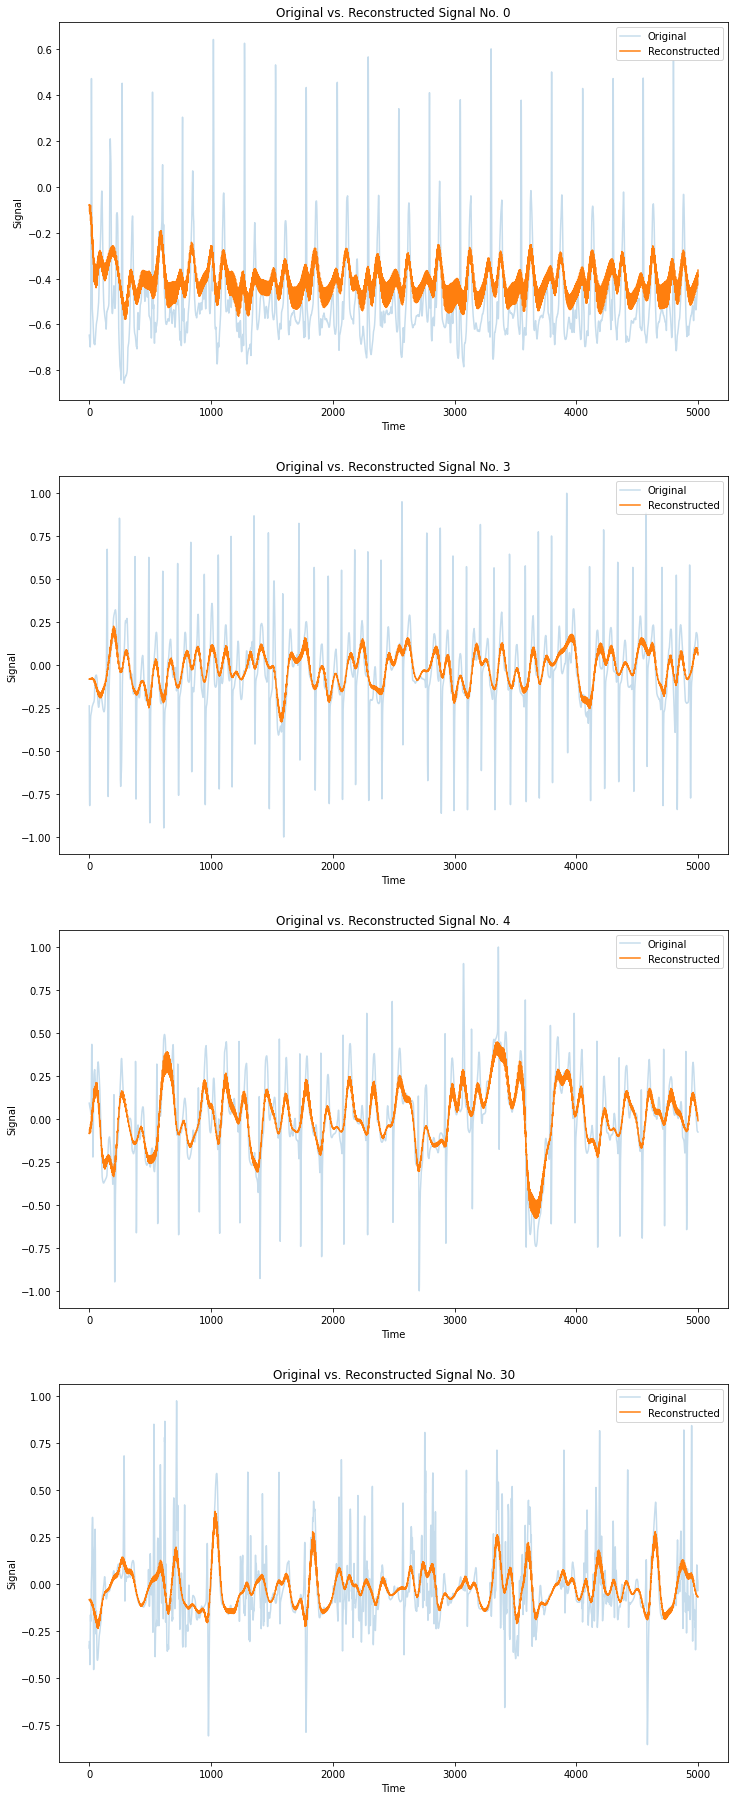

In [134]:
# Compare original with auto-encoded signal.
num_rows = 4
num_cols = 1
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12 * num_cols, 8 * num_rows))

fig.set_facecolor('white')

samples = [0, 3, 4, 30]
opacity = 0.25
time_limit = 5000


with torch.no_grad():
    ecg_auto_encoder.eval()

    for plot_idx, sample in enumerate(samples):
        axs[plot_idx].plot(list(range(time_limit)), X_train_scaled.iloc[sample, np.r_[:time_limit]], alpha=opacity, label='Original')

        signal_tensor = torch.tensor(X_train_scaled.iloc[sample].values, dtype=torch.float)
        signal_tensor = torch.unsqueeze(signal_tensor, 0)
        signal_tensor = torch.unsqueeze(signal_tensor, 0)
        enc_dec_signal = ecg_auto_encoder.reconstruct(signal_tensor)
        enc_dec_signal = torch.squeeze(enc_dec_signal)

        axs[plot_idx].plot(list(range(time_limit)), enc_dec_signal[:time_limit], label='Reconstructed')
        axs[plot_idx].set(xlabel='Time', ylabel='Signal', title=f'Original vs. Reconstructed Signal No. {sample}')
        axs[plot_idx].legend(loc='upper right')

plt.show()

## Classification with Encoded Signals

In [63]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

In [114]:
# Compute encoded version of training set.
with torch.no_grad():
    ecg_auto_encoder.eval()
    X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float)
    X_train_tensor = torch.unsqueeze(X_train_tensor, 1)
    X_train_enc = ecg_auto_encoder(X_train_tensor)
    X_train_enc = torch.squeeze(X_train_enc)
    X_train_enc = pd.DataFrame(X_train_enc.numpy(), index=X_train.index)
    display(X_train_enc)

,0,1,2,3,4,5,6,7,8,9,...,544,545,546,547,548,549,550,551,552,553
id,,,,,,,,,,,,,,,,,,,,,
0,0.698973,0.143187,0.530477,0.304547,0.314796,0.282814,0.389329,0.560666,0.730096,0.263061,...,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082
1,-0.758331,0.026239,0.482221,0.251282,0.474250,0.708788,0.633524,0.386743,0.501613,0.588076,...,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082
2,0.239613,0.240985,0.084029,0.415149,0.376256,0.311735,0.390863,0.357543,0.257087,0.190118,...,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082
3,0.117824,0.282916,0.147150,0.056164,-0.319399,-0.468745,0.061292,-0.081051,-0.303885,0.072775,...,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082
4,-0.467998,-0.096251,0.544115,0.194904,0.310251,0.453961,-0.339562,-0.306744,-0.094199,0.094832,...,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5112,0.458973,0.240963,-0.483033,-0.651145,-0.174200,0.125563,-0.234022,0.037597,0.273430,0.591858,...,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082
5113,0.548044,0.509842,0.549137,0.750822,0.753980,0.585896,0.350255,0.374863,0.396348,0.257146,...,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082
5114,-0.152503,-0.063694,0.479064,0.725636,0.439697,0.495278,0.440653,0.299785,0.299274,0.197871,...,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082,-0.043082


In [65]:
enc_valid_score = cross_val_score(
    GradientBoostingClassifier(random_state=42),
    X_train_enc,
    pd.Series.ravel(y_train),
    cv=5,
    scoring='f1_micro',
    verbose=4,
    n_jobs=-1).mean()
print(enc_valid_score)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 34.3min remaining: 51.5min


0.584719040200391


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 52.9min finished


In [ ]:
raw_valid_score = cross_val_score(
    LinearSVC(tol=1e-2),
    X_train,
    pd.Series.ravel(y_train),
    cv=5,
    scoring='f1_micro',
    verbose=4,
    n_jobs=-1).mean()
print(raw_valid_score)